# 1.) Define the project
-------------------------

In this notebook, I will be training several different classifiers to analyze handwriting, using the MNIST dataset. The challenge here is to keep the time required to train the classifiers low, as it could easily take a great deal of time. For each classifier, I will devote four cells to tuning its hyperparameters. After each classifier's hyperparameters have been tuned, I will combine these models into one voting classifier, with the hopes of performing better than each single classifier.

The three classifiers I will be using are a SGD Classifier and SVM classifiers with both "poly" and "rbf" kernels. The classification problem here is quite complicated, so we demand powerful algorithms to solve them.

The layout of the notebook is as follows. In Section (2), I will download the dataset and briefly look at the data to get a general understanding of it before I begin analysis. In Section (3), I will train my three classifiers and tune their hyperparameters. For each classifier, I will first sweep out a large swath of parameter space coarsely, then sweep more finely based on the results of the coarse hyperparameter tuning. The fine hyperparameter tuning will provide the best model of its type, and this will be the model I ultimately use on the testing data. For each set of hyperparameters, I will employ 3-fold cross-validation. In Section (4), I will train the voting classifier, using hard-voting. In Section (5), I will predict on the testing data, and I will analyze the performance of my model(s).

# 2.) Download / inspect the data
------------------------------

First, I fetch the data from sklearn's datasets. This takes a bit of time because the dataset is so large. Let us look at the shape of the data, as well as a few entries.

In [1]:
import time
import numpy as np

In [2]:
from sklearn import datasets
X, y = datasets.fetch_openml('mnist_784', return_X_y=True)
X.shape, y.shape

((70000, 784), (70000,))

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, test_idx = next(split.split(X,y))
X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]

print(y_train[0])
print(X_train[0])
print(y_train[:10])

9
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  25.  78. 155. 255. 255. 254. 227.  25.   0.   0.   0.   0.   0.   0.
   0

Scale the data to make it more amenable to ML algorithims

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Let's look at a few images -- how clear is it that these numbers are what they're supposed to be? As it turns out, quite clear.

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
def plot_num(i, data='train'):
  if data == 'train':  some_digit = X_train[i]
  else:                some_digit = X_test[i]
  some_digit_image = some_digit.reshape(28, 28)
  plt.imshow(some_digit_image, cmap=mpl.cm.binary)
  plt.axis("off")

  if data == 'train':  print('Actual number:', y_train[i])
  else:                print('Actual number:', y_test[i])

  plt.show()

Actual number: 9


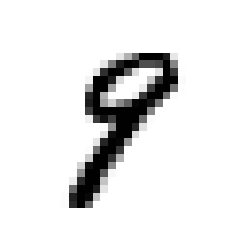

Actual number: 9


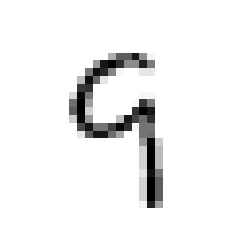

Actual number: 6


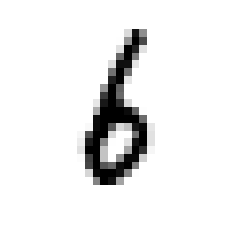

Actual number: 2


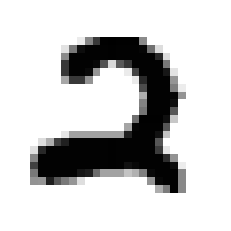

Actual number: 8


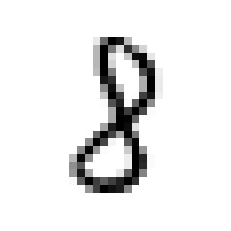

In [6]:
for i in range(5):
  plot_num(i)

In [6]:
def print_times(t2, t1):
    print('This took %.2f seconds' %(t2-t1))
    print('This took %.2f minutes' %((t2-t1)/60))
    print('This took %.2f hours' %((t2-t1)/3600))

In [7]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score
def time_model_whole_dataset(clf):
    t1 = time.time()
    ovo_clf = OneVsOneClassifier(clf)
    ovo_clf.fit(X_train_scaled, y_train)
    t2 = time.time()
    print_times(t2,t1)

Now, we are going to get a baseline time test for each type of model we will be using. It's important to get a sense of the time so that we can train and cross-validate an appropriate number of times (and not, say, make the code run for 100 hours on one model).

In [9]:
# test the speed of a SGD classifier over the whole dataset
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(random_state=623, max_iter=1e3, tol=1e-3)
time_model_whole_dataset(clf) # should take about 40 seconds

This took 24.12 seconds
This took 0.40 minutes
This took 0.01 hours


In [8]:
# test the speed of a polynomial SVC classifier over the whole dataset
from sklearn.svm import SVC
clf = SVC(kernel='poly', C=10.0, degree=5, coef0=1, gamma='scale')
time_model_whole_dataset(clf) # should take about 10 minutes

This took 327.21 seconds
This took 5.45 minutes
This took 0.09 hours


In [11]:
# test the speed of an rbf SVC classifier over the whole dataset
from sklearn.svm import SVC
clf = SVC(kernel='rbf', C=10.0, gamma=0.001)
time_model_whole_dataset(clf) # should take about 10 minutes

This took 448.80 seconds
This took 7.48 minutes
This took 0.12 hours


# 3.) Training the three classifiers
----------------------------

Now we wove onto the main section of this project. Each classifier will have four cells dedicated to it: two for coarse hyperparameter tuning, two for fine hyperparameter tuning. In each set of two cells, one will train and cross-validate the data across the hyperparameter-space, while the other is mainly for plotting to show the accuracy across different values of hyperparameters. The training/cross-validating cells are the ones that take a while. In each, I provide a rough time estimate; your results (with a different computer) may vary.

First, we begin with the SGDClassifier. The hyperparameter to tune here is $\alpha$.

In [12]:
# training a bunch of SGDClassifiers, surveying hyperparameter space
# vary alpha, train on whole dataset
# expect each one to take ~ 2mins per train
# check the alphas broadly at first, narrower later
from sklearn.model_selection import cross_val_score
SGD_alphas_coarse = 10**np.arange(-3.0, 3, 1) # 2mins x 6 models = 12 mins total
SGD_scores_coarse = np.zeros(len(SGD_alphas_coarse))

t1 = time.time()
for i in range(len(SGD_alphas_coarse)):
    print(i+1, '/', len(SGD_alphas_coarse))
    alpha = SGD_alphas_coarse[i]
    clf = SGDClassifier(random_state=623, max_iter=1000, tol=1e-3, alpha=alpha)
    ovo_clf = OneVsOneClassifier(clf)
    scores = cross_val_score(ovo_clf, X_train_scaled, y_train, scoring='accuracy', cv=3)
    SGD_scores_coarse[i] = np.average(scores)
t2 = time.time()
print_times(t2,t1)
# actually like 4 minutes

1 / 6
2 / 6
3 / 6
4 / 6
5 / 6
6 / 6
This took 161.28 seconds
This took 2.69 minutes
This took 0.04 hours


Best alpha: 0.010
Best accuracy: 0.9373


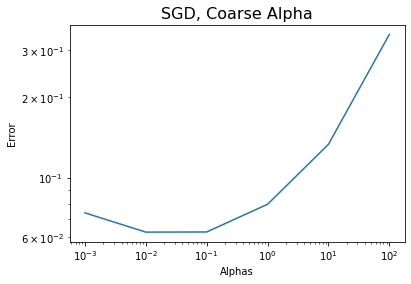

In [13]:
best_SGD_score_coarse = SGD_scores_coarse.max()
best_SGD_alpha_coarse = SGD_alphas_coarse[SGD_scores_coarse==best_SGD_score_coarse][0]
print('Best alpha: %.3f' %best_SGD_alpha_coarse)
print('Best accuracy: %.4f' %best_SGD_score_coarse)

plt.plot(SGD_alphas_coarse, 1-SGD_scores_coarse)
plt.xlabel('Alphas')
plt.ylabel('Error')
plt.title('SGD, Coarse Alpha', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [10]:
# refine the alphas for SGDClassifiers more
SGD_alphas_fine = 10**np.arange(-2.5, -0.5, 0.1) # 2mins x 20 models = 40 mins total
SGD_scores_fine = np.zeros(len(SGD_alphas_fine))

t1 = time.time()
for i in range(len(SGD_alphas_fine)):
    print(i+1, '/', len(SGD_alphas_fine))
    alpha = SGD_alphas_fine[i]
    clf = SGDClassifier(random_state=623, max_iter=1000, tol=1e-3, alpha=alpha)
    ovo_clf = OneVsOneClassifier(clf)
    scores = cross_val_score(ovo_clf, X_train_scaled, y_train, scoring='accuracy', cv=3)
    SGD_scores_fine[i] = np.average(scores)
t2 = time.time()
print_times(t2,t1)
# actually like 10 minutes

1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20
This took 486.72 seconds
This took 8.11 minutes
This took 0.14 hours


Best alpha: 0.040
Best accuracy: 0.9399


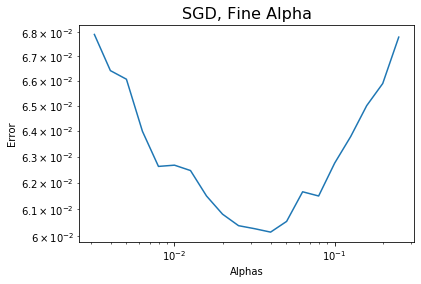

In [11]:
# plot the fine-search alphas / scores
best_SGD_score_fine = SGD_scores_fine.max()
best_SGD_alpha_fine = SGD_alphas_fine[SGD_scores_fine==best_SGD_score_fine][0]
print('Best alpha: %.3f' %best_SGD_alpha_fine)
print('Best accuracy: %.4f' %best_SGD_score_fine)

best_SGD_model = OneVsOneClassifier(SGDClassifier(
                        max_iter=1000, tol=1e-3, alpha=best_SGD_alpha_fine))

plt.plot(SGD_alphas_fine, 1-SGD_scores_fine)
plt.xlabel('Alphas')
plt.ylabel('Error')
plt.title('SGD, Fine Alpha', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.show()

Having now found the best SGD Classifier, we move onto the SVM models, starting with a polynomial kernel. The hyperparameters to tune here are $C$ and $d$. For this model, performing cross-validation on the whole training set would take far too long on each model. Instead, I choose my own data subset, effectively implementing my own bagging routine. For some reason, the sklearn BaggingClassifier *really* did not like doing cross-validation.

In [16]:
# training a bunch of poly-kernel SVC models, surveying hyperparameter space
# vary C and degree, train on a subset of the dataset
# expect each one to take ~ 30sec per train
# check C and degree broadly at first, then select a degree and hone in on C
poly_Cs_coarse = 10.0**np.arange(-3, 3, 1)
poly_degrees_coarse = range(3, 7)
# 2min x 6 x 4 models = 48min to train the whole thing
poly_scores_coarse = np.zeros(shape=(len(poly_Cs_coarse), len(poly_degrees_coarse)))

size = int(0.05*len(X_train))
np.random.seed(623)

t1 = time.time()
for i in range(len(poly_Cs_coarse)):
    print(i+1, '/', len(poly_Cs_coarse))
    C = poly_Cs_coarse[i]
    for j in range(len(poly_degrees_coarse)):
        print('\t', j+1, '/', len(poly_degrees_coarse))
        degree = poly_degrees_coarse[j]
        clf = SVC(kernel='poly', coef0=1, C=C, degree=degree, gamma='scale')
        ovo_clf = OneVsOneClassifier(clf)
        
        # I'll have to draw my own random subset, since for some reason BaggingClassifier
        #     refused to work with cross_val_score
        idxs = np.random.randint(0, len(X_train), size=size)
        Xhere = X_train_scaled[idxs]
        yhere = y_train[idxs]
        
        scores = cross_val_score(ovo_clf, Xhere, yhere, scoring='accuracy', cv=3)
        poly_scores_coarse[i,j] = np.average(scores)
t2 = time.time()
print_times(t2,t1)
# actually like 20 minutes

1 / 6
	 1 / 4
	 2 / 4
	 3 / 4
	 4 / 4
2 / 6
	 1 / 4
	 2 / 4
	 3 / 4
	 4 / 4
3 / 6
	 1 / 4
	 2 / 4
	 3 / 4
	 4 / 4
4 / 6
	 1 / 4
	 2 / 4
	 3 / 4
	 4 / 4
5 / 6
	 1 / 4
	 2 / 4
	 3 / 4
	 4 / 4
6 / 6
	 1 / 4
	 2 / 4
	 3 / 4
	 4 / 4
This took 1048.66 seconds
This took 17.48 minutes
This took 0.29 hours


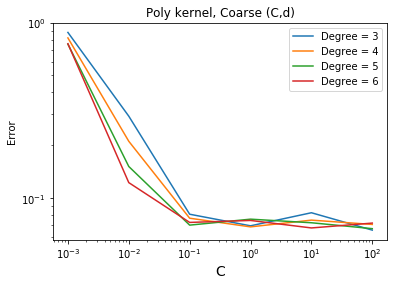

In [17]:
for i in range(len(poly_degrees_coarse)):
    degree = poly_degrees_coarse[i]
    scores = poly_scores_coarse[:,i]
    plt.plot(poly_Cs_coarse, 1-scores, label = 'Degree = ' + str(degree))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('C', fontsize=14)
plt.ylabel('Error')
plt.title('Poly kernel, Coarse (C,d)')
plt.legend()
plt.show()

In [12]:
# pick a polynomial degree and fine-search for a C here
# expect each one to take roughly 30 sec to train
# degree 5 has lowest cv error at all Cs
# 2min x 20 models = 40min to train the whole thing
poly_degree_fine = 5
poly_Cs_fine = 10**np.arange(0, 2, 0.1)
poly_scores_fine = np.zeros(len(poly_Cs_fine))

size = int(0.05*len(X_train))
np.random.seed(623)
t1 = time.time()
for i in range(len(poly_Cs_fine)):
    print(i+1, '/', len(poly_Cs_fine))
    C = poly_Cs_fine[i]
    clf = SVC(kernel='poly', coef0=1, C=C, degree=poly_degree_fine, gamma='scale')
    ovo_clf = OneVsOneClassifier(clf)
    
    # I'll have to draw my own random subset, since for some reason BaggingClassifier
    #     refused to work with cross_val_score
    idxs = np.random.randint(0, len(X_train), size=size)
    Xhere = X_train_scaled[idxs]
    yhere = y_train[idxs]
        
    scores = cross_val_score(ovo_clf, Xhere, yhere, scoring='accuracy', cv=3)
    poly_scores_fine[i] = np.average(scores)
t2 = time.time()
print_times(t2,t1)
# actually like 10 minutes

1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20
This took 567.55 seconds
This took 9.46 minutes
This took 0.16 hours


Best poly C: 15.849
Best accuracy: 0.9362


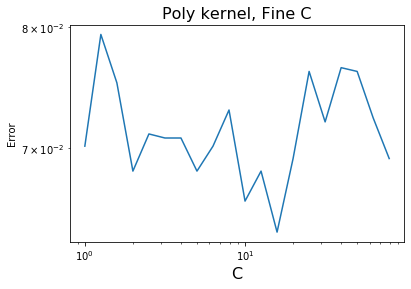

In [13]:
# plot the fine-search poly scores here
best_poly_score_fine = poly_scores_fine.max()
best_poly_C_fine = poly_Cs_fine[poly_scores_fine==best_poly_score_fine][0]
print('Best poly C: %.3f' %best_poly_C_fine)
print('Best accuracy: %.4f' %best_poly_score_fine)

best_poly_model = OneVsOneClassifier(SVC(kernel='poly', coef0=1, gamma='scale',
                                         C=best_poly_C_fine, degree=poly_degree_fine))

plt.plot(poly_Cs_fine, 1-poly_scores_fine)
plt.xlabel('C', fontsize=16)
plt.ylabel('Error')
plt.title('Poly kernel, Fine C', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.show()

Finally, we move onto the last classifier: SVM with rbf kernel. The hyperparameters to tune here are $C$ and $\gamma$. Subsets of the data are drawn to ensure the code runs in a timely manner. Again, I implement my own bagging routine, since sklearn's BaggingClassifier refuses to work in a timely manner with cross_val_score.

In [20]:
# training a bunch of rbf-kernel SVC models, surveying hyperparameter space
# vary C and gamma, train on a subset of the dataset
# expect each one to take ~ 2min per train
# check C and gamma broadly at first, then select a smaller space and look more closely
rbf_Cs_coarse = 10.0**np.arange(-3, 3, 1)
rbf_gammas_coarse = 10.0**np.arange(-4, -1, 1)
# 2min x 3 x 6 models = 36mins to train the whole thing
rbf_scores_coarse = np.zeros(shape=(len(rbf_Cs_coarse), len(rbf_gammas_coarse)))

size = int(0.04*len(X_train))
np.random.seed(623)

t1 = time.time()
for i in range(len(rbf_Cs_coarse)):
    print(i+1, '/', len(rbf_Cs_coarse))
    C = rbf_Cs_coarse[i]
    for j in range(len(rbf_gammas_coarse)):
        print('\t', j+1, '/', len(rbf_gammas_coarse))
        gamma = rbf_gammas_coarse[j]
        clf = SVC(kernel='rbf', C=C, gamma=gamma)
        ovo_clf = OneVsOneClassifier(clf)
        
        # I'll have to draw my own random subset, since for some reason BaggingClassifier
        #     refused to work with cross_val_score
        idxs = np.random.randint(0, len(X_train), size=size)
        Xhere = X_train_scaled[idxs]
        yhere = y_train[idxs]
        
        scores = cross_val_score(ovo_clf, Xhere, yhere, scoring='accuracy', cv=3)
        rbf_scores_coarse[i,j] = np.average(scores)
t2 = time.time()
print_times(t2,t1)
# actually like 18 mins

1 / 6
	 1 / 3
	 2 / 3
	 3 / 3
2 / 6
	 1 / 3
	 2 / 3
	 3 / 3
3 / 6
	 1 / 3
	 2 / 3
	 3 / 3
4 / 6
	 1 / 3
	 2 / 3
	 3 / 3
5 / 6
	 1 / 3
	 2 / 3
	 3 / 3
6 / 6
	 1 / 3
	 2 / 3
	 3 / 3
This took 787.25 seconds
This took 13.12 minutes
This took 0.22 hours


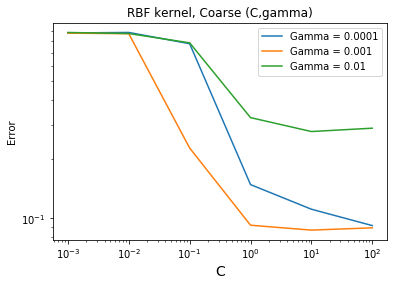

In [21]:
for i in range(len(rbf_gammas_coarse)):
    gamma = rbf_gammas_coarse[i]
    scores = rbf_scores_coarse[:,i]
    plt.plot(rbf_Cs_coarse, 1-scores, label = 'Gamma = ' + str(gamma))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('C', fontsize=14)
plt.ylabel('Error')
plt.title('RBF kernel, Coarse (C,gamma)')
plt.legend()
plt.show()

In [14]:
# more finely study C and gamma, based on the results of the coarse study
# vary C and gamma, train on a subset of the dataset
# expect each one to take ~ 2min per train
rbf_Cs_fine = 10.0**np.arange(0.5, 1.5, 0.2)
rbf_gammas_fine = 10.0**np.arange(-3.5, -2.5, 0.2)
#rbf_gamma = 0.001
# 2min x 5 x 5 models = 50mins to train the whole thing
rbf_scores_fine = np.zeros(shape=(len(rbf_Cs_fine), len(rbf_gammas_fine)))

size = int(0.04*len(X_train))
np.random.seed(623)

t1 = time.time()
for i in range(len(rbf_Cs_fine)):
    print(i+1, '/', len(rbf_Cs_fine))
    C = rbf_Cs_fine[i]
    for j in range(len(rbf_gammas_fine)):
        print('\t', j+1, '/', len(rbf_gammas_fine))
        gamma = rbf_gammas_fine[j]
        clf = SVC(kernel='rbf', C=C, gamma=gamma)
        ovo_clf = OneVsOneClassifier(clf)
        
        # I'll have to draw my own random subset, since for some reason BaggingClassifier
        #     refused to work with cross_val_score
        idxs = np.random.randint(0, len(X_train), size=size)
        Xhere = X_train_scaled[idxs]
        yhere = y_train[idxs]
        
        scores = cross_val_score(ovo_clf, Xhere, yhere, scoring='accuracy', cv=3)
        rbf_scores_fine[i,j] = np.average(scores)
t2 = time.time()
print_times(t2,t1)
# actually like 10 mins

1 / 5
	 1 / 5
	 2 / 5
	 3 / 5
	 4 / 5
	 5 / 5
2 / 5
	 1 / 5
	 2 / 5
	 3 / 5
	 4 / 5
	 5 / 5
3 / 5
	 1 / 5
	 2 / 5
	 3 / 5
	 4 / 5
	 5 / 5
4 / 5
	 1 / 5
	 2 / 5
	 3 / 5
	 4 / 5
	 5 / 5
5 / 5
	 1 / 5
	 2 / 5
	 3 / 5
	 4 / 5
	 5 / 5
This took 490.54 seconds
This took 8.18 minutes
This took 0.14 hours


Best rbf C: 19.953
Best rbf gamma: 0.001
Best accuracy: 0.9210


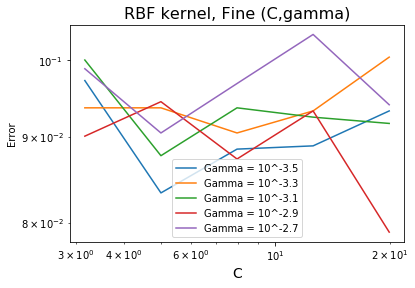

In [15]:
best_rbf_score_fine = rbf_scores_fine.max()
i1, i2 = np.where(rbf_scores_fine==best_rbf_score_fine)
best_rbf_C_fine = rbf_Cs_fine[i1[0]]
best_rbf_gamma_fine = rbf_gammas_fine[i2[0]]
print('Best rbf C: %.3f' %best_rbf_C_fine)
print('Best rbf gamma: %.3f' %best_rbf_gamma_fine)
print('Best accuracy: %.4f' %best_rbf_score_fine)

best_rbf_model = OneVsOneClassifier(SVC(kernel='rbf', gamma=best_rbf_gamma_fine, C=best_rbf_C_fine))

for i in range(len(rbf_gammas_fine)):
    gamma = rbf_gammas_fine[i]
    scores = rbf_scores_fine[:,i]
    plt.plot(rbf_Cs_fine, 1-scores, label = 'Gamma = 10^%.1f' %np.log10(gamma))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('C', fontsize=14)
plt.ylabel('Error')
plt.title('RBF kernel, Fine (C,gamma)', fontsize=16)
plt.legend()
plt.show()

# 4.) Training the voting classifier
------------------------------------

Having now trained all the classifiers, we move onto the voting classifier. Since each of the three voting members are well-trained classifiers, we implement "soft" voting rather than "hard" voting. In this section, we simply train the voting classifier.

In [16]:
# form a voting classifier from all the best classifiers so far
# this whole cell should take like 15 minutes to run
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('best sgd', best_SGD_model),
                ('best poly', best_poly_model),
                ('best rbf', best_rbf_model)], voting='hard')

t1 = time.time()
voting_clf.fit(X_train_scaled, y_train)
t2 = time.time()
print_times(t2, t1)

This took 851.30 seconds
This took 14.19 minutes
This took 0.24 hours


# 5.) Analyzing performance
-------------------------

Having now trained the voting classifier, we use it to predict on the testing set. Fingers crossed, I hope this works! If not, it would take literally days to try and train better classifiers....

In [18]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
ypred = voting_clf.predict(X_test_scaled)
mat = confusion_matrix(y_test, ypred)
print(mat)
print('Precision: %.3f' %precision_score(y_test, ypred, average='micro'))
print('Recall:    %.3f' %recall_score(y_test, ypred, average='micro'))
print('Accuracy:  %.3f' %accuracy_score(y_test, ypred))

[[684   1   1   0   1   0   2   0   1   0]
 [  0 782   1   1   1   0   0   0   3   0]
 [  2   1 682   3   1   0   0   5   4   1]
 [  1   1   2 688   1   8   0   5   5   3]
 [  0   0   3   0 665   1   2   3   0   8]
 [  0   0   0   3   1 613   8   1   3   2]
 [  2   0   1   0   1   0 684   0   0   0]
 [  1   3   4   0   5   0   0 706   0  10]
 [  2   1   6   5   1   5   1   3 655   4]
 [  1   3   2   5   6   1   0   9   2 667]]
Precision: 0.975
Recall:    0.975
Accuracy:  0.975


In [19]:
acc = accuracy_score(y_test, ypred)
err = (1-acc)*100
MyScore = 35-25*np.log10(err-1)
MyScore

30.701617517886874

In [17]:
# pickle the models to avoid having to re-train every time the kernel is restarted
import pickle
models = [best_SGD_model, best_poly_model, best_rbf_model, voting_clf]
names = ['sgd_final', 'poly_final', 'rbf_final', 'voting_final']
for model, name in zip(models, names):
    pickle.dump(model, open(name, 'wb'))

In [20]:
# this cell exists to load in the pickled models
import pickle
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score


best_poly_model = pickle.load(open('poly_final', 'rb'))
best_SGD_model = pickle.load(open('sgd_final', 'rb'))
best_rbf_model = pickle.load(open('rbf_final', 'rb'))